In [446]:
import nengo
import numpy as np
import scipy
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt



# Parameters

In [512]:
#Parameters
#Simulation
adaptive_on = True
sim_time = 20

#basis = 'Random'
basis = 'Selected'
#basis = 'SSP'

#System Parameters
m = 1
g = 9.8
l = 1
b = 0.05
dt = 0.001

#Controller
ks = 20
lam = 0.7
weight_update_rate = 2e-4
ref_sig = lambda t: [0.5*np.sin(t), 0.5*np.cos(t)]

#Nengo
num_neurons = 1000
basis_neurons = 100
probe_synapse = 0.01
neuron_type = nengo.LIF()

#Selected Basis
limits = [[-np.pi,np.pi],[-np.pi,np.pi]]
x_mean = [0,0] #X mean, X dot mean
gain = 100
rho_specified = 0.421

#SSP 
domain_ranges_ = np.array([[-np.pi,np.pi],[-10.,10.]])
ssp_dim = 512
rho_specified = 0.421
#encoders_type = 'random'
encoders_type = 'place-cells'
psd_sampling = 'gaussian'
length_scale = np.asarray([[0.82,5.31]])
gain = 100


# Functions


In [513]:
class pen: #Without Disturbance
    def __init__(self,dt,m,l,b):
        self.dt = dt
        self.m = m
        self.l = l
        self.b = b
        self.dt = dt
        self.g = 9.81
    def __call__(self,t, x):
        # X[0:2] = [X, Xdot, U]
        f_x = np.asarray([ x[1] , -(self.g/(self.l*self.m)) * np.sin(x[0]) - (self.b/self.m)*x[1] + x[2]/self.m])
        return x[0:2] + f_x * dt

#For selected basis
#Chooses encoders on D+1 hypersphere
def projection(X): 
    n = len(X) + 1
    X_proj = np.zeros(n)
    X_proj[-1] =  np.prod(np.sin(X))
    for i in range(n-2, -1, -1):
        X_proj[i] = np.prod(np.sin(X[:i])) * np.cos(X[i])
    return X_proj
def selected_encoders(dim,num_neurons):
    X = np.zeros((dim,num_neurons))
    for d in range(dim):
        X[d,:] = np.linspace(-np.pi,np.pi,num_neurons)
    X_proj = np.zeros((dim+1,num_neurons))
    for n in range(num_neurons):
        X_proj[:,n] = projection(X[:,n])
    return np.transpose(X_proj)
    
def sparsity_to_x_intercept(d, p):
    sign = 1
    if p > 0.5:
        p = 1.0 - p
        sign = -1
    return sign * np.sqrt(1-scipy.special.betaincinv((d-1)/2.0, 0.5, 2*p))

def make_unitary_matrix_fourier( ssp_dim, domain_dim, eps=1e-3, rng = np.random, psd_sampling = 'uniform' ):
    if psd_sampling == 'gaussian':
        # gaussian kernel
        a = rng.normal( loc = 0., scale = 1., size = ( (ssp_dim - 1)//2, domain_dim) )
        phi = np.pi * (eps + a * (1 - 2 * eps))
    
    elif psd_sampling == 'uniform':
        # sinc kernel
        a = rng.rand( (ssp_dim - 1)//2, domain_dim )
        sign = rng.choice((-1, +1), size=np.shape(a) )
        phi = sign * np.pi * (eps + a * (1 - 2 * eps))
    
    fv = np.zeros( (ssp_dim,domain_dim), dtype='complex64')
    fv[0,:] = 1

    fv[1:(ssp_dim + 1) // 2,:] = phi
    fv[-1:ssp_dim // 2:-1,:] = -fv[1:(ssp_dim + 1) // 2,:]
    
    if ssp_dim % 2 == 0:
        fv[ssp_dim // 2,:] = 1

    return fv

class SSPEncoder:
    def __init__(self, phase_matrix, length_scale):
        '''
        Represents a domain using spatial semantic pointers.

        Parameters:
        -----------

        phase_matrix : np.ndarray
            A ssp_dim x domain_dim ndarray representing the frequency 
            components of the SSP representation.

        length_scale : float or np.ndarray
            Scales values before encoding.
        '''
        self.phase_matrix = phase_matrix

        self.domain_dim = self.phase_matrix.shape[1]
        self.ssp_dim = self.phase_matrix.shape[0]
        self.update_lengthscale(length_scale)

    def update_lengthscale(self, scale):
        '''
        Changes the lengthscale being used in the encoding.
        '''
        if not isinstance(scale, np.ndarray) or scale.size == 1:
            self.length_scale = scale * np.ones((self.domain_dim,))
        else:
            assert scale.size == self.domain_dim
            self.length_scale = scale
        assert self.length_scale.size == self.domain_dim
    
    def encode(self,x):
        '''
        Transforms input data into an SSP representation.

        Parameters:
        -----------
        x : np.ndarray
            A (num_samples, domain_dim) array representing data to be encoded.

        Returns:
        --------
        data : np.ndarray
            A (num_samples, ssp_dim) array of the ssp representation of the data
            
        '''
        
        x = np.atleast_2d(x)
        ls_mat = np.atleast_2d(np.diag(1/self.length_scale.flatten()))
        
        assert ls_mat.shape == (self.domain_dim, self.domain_dim), f'Expected Len Scale mat with dimensions {(self.domain_dim, self.domain_dim)}, got {ls_mat.shape}'
        scaled_x = x @ ls_mat
        data = np.fft.ifft( np.exp( 1.j * self.phase_matrix @ scaled_x.T), axis=0 ).real
        
        return data.T

def RandomSSPSpace(domain_dim, ssp_dim, length_scale = None, 
                   rng = np.random.default_rng(), psd_sampling = 'uniform' ):
    
    phase_matrix = make_unitary_matrix_fourier(ssp_dim,domain_dim, psd_sampling = psd_sampling )

    if isinstance(length_scale,float):
        length_scale = np.array( np.tile(length_scale,domain_dim) )
    else:
        length_scale = np.array( length_scale )
    return SSPEncoder(phase_matrix, length_scale=length_scale)
    
    
def encode_rff( x, n_features, length_scale, kernel = 'gaussian', coefficient = 1., n_functions = 1):
    # print(type(x))
    
    # dimensionality of feature space
    x_dim = x.shape[-1]
    omega_shape = (n_functions, n_features, x_dim)
    
    if kernel == 'gaussian':
        omega = np.random.normal( size = omega_shape )
        
    # Scale omegas by lengthscale
    omega = omega / length_scale

    phi = np.random.uniform( low = 0., high = (2 * np.pi), size = (n_functions, n_features, 1) )
    
    features = np.cos( np.einsum('sfd, nd -> sfn', omega, x) + phi)
    features = (2 / n_features) ** 0.5 * features * coefficient

    return features[0,:,:].T

# Simulation

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Text(0.5, 1.0, 'Error, RMSE: 0.0478')

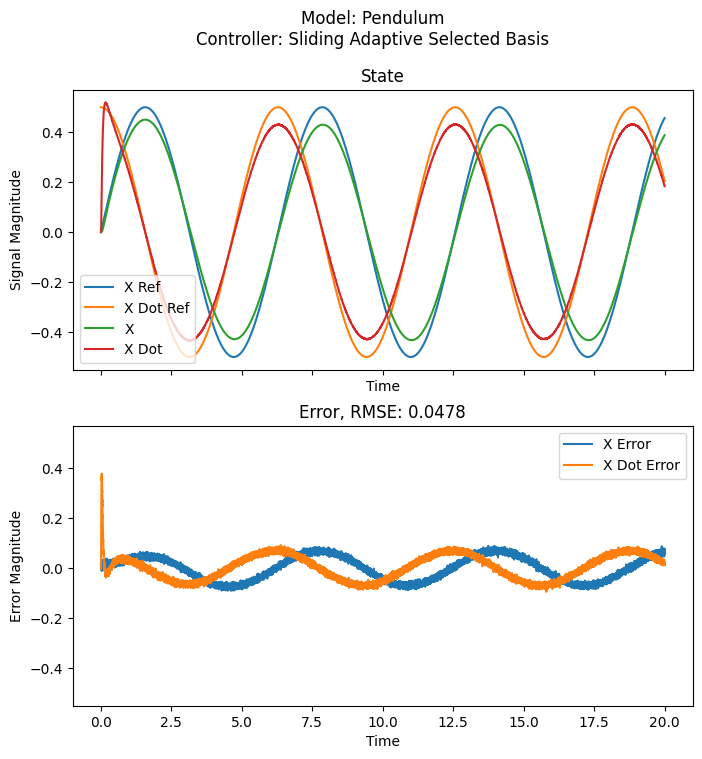

In [514]:
model = nengo.Network()
with model:
    def Sliding_Mode(e): #Defines sliding surface
        return e[1] + lam*e[0]
    def Controller(e): #Generates control signal
        s = Sliding_Mode(e)
        g_x = m
        return (1/g_x)*(ks*s + lam*e[1])
    def projection(X): #Projects states into D+1 hypersphere (Selected basis only)
        X = np.divide(X-x_mean,np.asarray(limits)[:,1])
        n = len(X) + 1
        X_proj = np.zeros(n)
        X_proj[-1] =  np.prod(np.sin(X))
        for i in range(n-2, -1, -1):
            X_proj[i] = np.prod(np.sin(X[:i])) * np.cos(X[i])
        return X_proj
    #Nodes
    sys = nengo.Node(pen(dt,m,l,b),size_in = 3) #input = [x,xdot,u], output = [x,xdot]
    ref = nengo.Node( ref_sig) #ref = [Xdes, Xdotdes]
    
    #Ensemble
    err = nengo.Ensemble(num_neurons,2) #err = [e, edot]
    

    #Adaptive
    if(adaptive_on == True):
        match basis:
            case 'Random':
                adaptive_basis = nengo.Ensemble(basis_neurons,2,neuron_type = neuron_type) 
                adaptive_weights = nengo.Connection(adaptive_basis,sys[2], transform=np.zeros((1,2)), learning_rule_type=nengo.PES(learning_rate=weight_update_rate))
                learning_sig = nengo.Connection(err,adaptive_weights.learning_rule,transform = -1, function = Sliding_Mode)
                adaptive_input = nengo.Connection(sys,adaptive_basis)
                
            case 'Selected':
                xi = - sparsity_to_x_intercept( d = 3, p = rho_specified )
                adaptive_basis = nengo.Ensemble(basis_neurons,3,
                                                encoders = selected_encoders(2,basis_neurons),
                                                gain = gain*np.ones(basis_neurons),
                                                bias = np.zeros(basis_neurons)+xi,
                                                neuron_type = neuron_type) 
                adaptive_weights = nengo.Connection(adaptive_basis,sys[2], transform=np.zeros((1,3)), learning_rule_type=nengo.PES(learning_rate=weight_update_rate))
                learning_sig = nengo.Connection(err,adaptive_weights.learning_rule,transform = -1, function = Sliding_Mode)
                adaptive_input = nengo.Connection(sys,adaptive_basis, function = projection)
                
            case 'SSP':
                ssp_embedding = RandomSSPSpace( domain_dim = 2, 
                                                   ssp_dim = ssp_dim, 
                                                   length_scale = length_scale, 
                                                   psd_sampling = psd_sampling )
                xi = - sparsity_to_x_intercept( d = ssp_dim, p = rho_specified )
                
                def encode_ssp(t,x):
                    #print(x)
                    return ssp_embedding.encode(x).flatten()
            
                if encoders_type == 'random':
                    encoders = nengo.dists.UniformHypersphere(surface=True).sample(basis_neurons, ssp_dim)
                
                elif encoders_type == 'place-cells':
                    e_xs = np.random.uniform(low=domain_ranges_[:,0],high=domain_ranges_[:,1],size=(basis_neurons,ssp_embedding.domain_dim))
                    encoders = ssp_embedding.encode(e_xs)
            
                # create ensemble; random encoders for now
                adaptive_basis = nengo.Ensemble(n_neurons = basis_neurons, 
                                          dimensions = ssp_embedding.ssp_dim,
                                          gain = gain*np.ones(basis_neurons),
                                          bias = np.zeros(basis_neurons) + xi,
                                          neuron_type = neuron_type,
                                          encoders = encoders,
                                          normalize_encoders = False,
                                         )
                ssp_node = nengo.Node(encode_ssp,size_in=2)
                nengo.Connection(sys,ssp_node)
                nengo.Connection(ssp_node,adaptive_basis)            
                adaptive_weights = nengo.Connection(adaptive_basis,sys[2],transform = np.zeros((1,adaptive_basis.dimensions)),learning_rule_type=nengo.PES(learning_rate=weight_update_rate))
                learning_sig = nengo.Connection(err,adaptive_weights.learning_rule,function = Sliding_Mode,transform = -1) 
                

    #Connections
    reference_input = nengo.Connection(ref,err)
    feedback = nengo.Connection(sys, err, transform = -1)
    controller = nengo.Connection(err,sys[2],function = Controller)
    state_connection = nengo.Connection(sys,sys[0:2],synapse = 0)
    
    #Probes
    state_probe = nengo.Probe(target = sys, attr = 'output')
    reference_probe = nengo.Probe(target = ref, attr = 'output')
    err_probe = nengo.Probe(target = err, attr = 'decoded_output',synapse = probe_synapse)

with nengo.Simulator(model) as sim:
    sim.run(sim_time)

t = sim.trange()
ref_signal = sim.data[reference_probe]
state_signal = sim.data[state_probe]
err_signal = sim.data[err_probe]

RMSE = np.sqrt(np.mean((err_signal[:,0])**2))

#Plotting
fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True, sharey=True)
axes = axes.flatten()

fig.suptitle(f'Model: Pendulum\nController: Sliding Adaptive {basis} Basis')

axes[0].plot(t,ref_signal)
axes[0].plot(t,state_signal)
axes[0].legend(['X Ref','X Dot Ref','X','X Dot'])
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Signal Magnitude')
axes[0].set_title('State')

axes[1].plot(t,err_signal)
axes[1].legend(['X Error','X Dot Error'])
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Error Magnitude')
axes[1].set_title(f'Error, RMSE: {RMSE:.4f}')